# WWOX

WWOX encodes a 414-amino acid protein containing 2 WW domains coupled to a region with high homology to the short-chain dehydrogenase/reductase (SRD) family of enzymes.
[developmental and epileptic encephalopathy-28 (DEE28)](https://omim.org/entry/616211) and [ autosomal recessive spinocerebellar ataxia-12 (SCAR12)](https://omim.org/entry/614322) caused by biallelic mutation in the WWOX gene.

In [1]:
import gpsea
import hpotk

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo()
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")


Loaded HPO v2024-12-12
Using gpsea version 0.9.0


### WWOX
We user the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for WWOX.

In [2]:
gene_symbol = 'WWOX'
mane_tx_id = 'NM_016373.4'
mane_protein_id = "NP_057457.1" 

In [3]:
from ppktstore.registry import configure_phenopacket_registry
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets


phenopacket_store_release = '0.1.22'


registry = configure_phenopacket_registry()
with registry.open_phenopacket_store(phenopacket_store_release) as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))


cohort_creator = configure_caching_cohort_creator(hpo)
cohort, validation = load_phenopackets(
    phenopackets=phenopackets, 
    cohort_creator=cohort_creator,
)

validation.summarize()

Individuals Processed:   0%|          | 0/38 [00:00<?, ?individuals/s]

Expected a result but got an Error for variant: 16_78386858_78386858_A_--45894bp--
<html><body><h1>400 Bad request</h1>
Your browser sent an invalid request.
</body></html>



Individuals Processed: 100%|██████████| 38/38 [00:04<00:00,  9.08individuals/s]
Validated under permissive policy
Showing errors and warnings
Phenopackets
  patient #0
    variants
      #0
       warnings:
       ·Individual PMID_30356099_Patient_1 has an error with variant 16_78386858_78386858_A_--45894bp--. Try again or remove variant from testing... Expected a result but got an Error. See log for details.


In [4]:
from gpsea.view import CohortViewer
viewer = CohortViewer(hpo=hpo)
viewer.process(cohort=cohort, transcript_id=mane_tx_id)


n,HPO Term
36,Global developmental delay
32,EEG abnormality
29,Epileptic encephalopathy
20,Hypokinesia
19,Thin corpus callosum
19,Reduced eye contact
15,Spasticity
14,Cerebral atrophy
12,Bilateral tonic-clonic seizure
12,Epileptic spasm


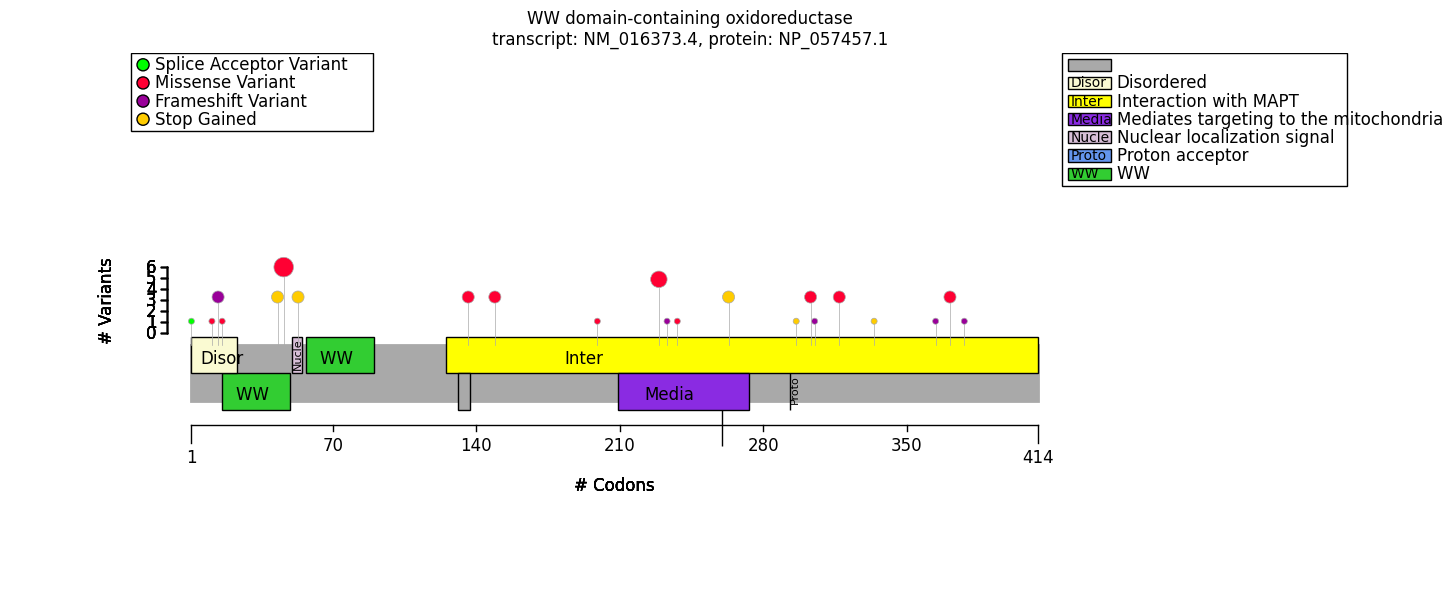

In [5]:
from gpsea.model.genome import GRCh38
from gpsea.preprocessing import configure_default_protein_metadata_service, VVMultiCoordinateService
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt

txc_service = VVMultiCoordinateService(genome_build=GRCh38)
pms = configure_default_protein_metadata_service()
tx_coordinates = txc_service.fetch(mane_tx_id)
protein_meta = pms.annotate(mane_protein_id)

wwox_fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein_diagram(
    tx_coordinates,
    protein_meta,
    cohort,
    ax=ax,
)
wwox_fig.tight_layout()

In [6]:
from gpsea.view import CohortVariantViewer
viewer = CohortVariantViewer(tx_id=mane_tx_id)
report = viewer.process(cohort=cohort)
report  

Count,Variant key,HGVS,Overlapping Exons,Effects
4,16_78424953_78424953_A_C,c.689A>C (p.Gln230Pro),7,missense
4,16_78108454_78108454_C_A,c.139C>A (p.Pro47Thr),2,missense
3,16_78386858_78425054_--38197bp--_A,c.517_791del (p.His173IlefsTer5),"6, 7","splice acceptor, splice donor, splice donor 5th base, coding sequence, intronic"
3,16_78386858_78432751_--45894bp--_A,c.517_1056del (p.His173_Met352del),"6, 7, 8","splice acceptor, splice donor, splice donor 5th base, coding sequence, intronic"
3,SO:1000029_HGNC:12799_WWOX,SV involving WWOX (p.?),,chromosomal deletion
2,16_78164222_78164222_A_C,c.449A>C (p.His150Pro),5,missense
2,16_78108455_78108455_C_G,c.140C>G (p.Pro47Arg),2,missense
2,16_78424868_78425054_--187bp--_A,c.607_791+1del (-),7,"splice acceptor, coding sequence"
2,16_78108475_78108475_C_T,c.160C>T (p.Arg54Ter),2,stop gained
2,16_78099822_78099826_AGGAC_A,c.46_49del (p.Asp16SerfsTer63),1,frameshift


In [7]:
from gpsea.view import ProteinVariantViewer

viewer = ProteinVariantViewer(protein_meta, mane_tx_id)
viewer.process(cohort)

Count,Name,Type,Coordinates,Variants
5,Disordered,Region,2 - 23,p.Glu17Lys; p.Asp16SerfsTer63; p.Thr12Met; p.Met1_?137
10,WW 1,Domain,17 - 49,p.Pro47Arg; p.Pro47Thr; p.Trp44Ter; p.Glu17Lys; p.Met1_?137
3,Nuclear localization signal,Motif,51 - 55,p.Arg54Ter; p.Met1_?137
1,WW 2,Domain,58 - 90,p.Met1_?137
25,Interaction with MAPT,Region,126 - 414,p.Trp335Ter; p.Glu306AspfsTer21; p.Ser304Phe; p.His150Pro; p.Gly372Arg; p.Leu239Arg; p.Gln230Pro; p.Ser318Leu; p.His236AlafsTer34; p.Ser304Tyr; p.Lys297Ter; p.Cys380LeufsTer149; p.Arg264Ter; p.Gly137Glu; p.Val365AlafsTer163; p.Lys200Glu; p.Met1_?137
3,,Binding site,132 - 137,p.Gly137Glu; p.Met1_?137
8,Mediates targeting to the mitochondria,Region,210 - 273,p.Arg264Ter; p.Leu239Arg; p.Gln230Pro; p.His236AlafsTer34
0,,Binding site,261 - 260,
0,Proton acceptor,Active site,294 - 293,


# Genotype-Phenotype Correlation (GPC) Analysis

Several GPC ideas were developed mainly through accurate reading of "The phenotypic spectrum of WWOX-related disorders: 20
additional cases of WOREE syndrome and review of the literature" by orcid:0000-0002-6912-8518.

In [8]:
from gpsea.analysis.pcats import configure_hpo_term_analysis
analysis = configure_hpo_term_analysis(hpo)

#from gpsea.analysis.predicate.phenotype import prepare_predicates_for_terms_of_interest
from gpsea.analysis.clf import prepare_classifiers_for_terms_of_interest
pheno_predicates = prepare_classifiers_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

In [9]:
# MISSENSE --> nothing found

from gpsea.view import MtcStatsViewer
from gpsea.model import VariantEffect
from gpsea.analysis.predicate import variant_effect, anyof
from gpsea.analysis.clf import biallelic_classifier
from gpsea.view import summarize_hpo_analysis


is_missense = variant_effect(VariantEffect.MISSENSE_VARIANT, tx_id=mane_tx_id)

missense_predicate = biallelic_classifier(
    a_predicate=is_missense,
    b_predicate=~is_missense,
    a_label="Missense",
    b_label="Other",
    partitions=((0,1), (2,))
)
missense_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=missense_predicate,
    pheno_clfs=pheno_predicates,
)

viewer = MtcStatsViewer()
viewer.process(missense_result)
#summarize_hpo_analysis(hpo=hpo, result=missense_result)

Code,Reason,Count
HMF01,Skipping term with maximum frequency that was less than threshold 0.4,20
HMF03,Skipping term because of a child term with the same individual counts,7
HMF08,Skipping general term,53
HMF09,Skipping term with maximum annotation frequency that was less than threshold 0.4,134


In [10]:
from gpsea.analysis.predicate import protein_feature

interaction_mapt = protein_feature("Interaction with MAPT", protein_metadata=protein_meta)
#interaction_mapt = protein_feature("Mediates targeting to the mitochondria", protein_metadata=protein_meta) # nothing found here
mapt_predicate = biallelic_classifier(
    a_predicate=interaction_mapt,
    b_predicate=~interaction_mapt,
    a_label="MAPT Interaction",
    b_label="Other",
    partitions=((0,1), (2,)) # seems to show one correlation, could be biased by having tried hard to find something
)
mapt_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=mapt_predicate,
    pheno_clfs=pheno_predicates,
)
summarize_hpo_analysis(hpo=hpo, result=mapt_result)

Allele group                                       MAPT Interaction/MAPT Interaction OR MAPT Interaction/Other  \
                                                                                                         Count   
Bilateral tonic-clonic seizure with focal onset...                                               0/18            
Hypokinesia [HP:0002375]                                                                        16/17            
Short neck [HP:0000470]                                                                          1/16            
Decreased fetal movement [HP:0001558]                                                            2/16            
Epileptic spasm [HP:0011097]                                                                    10/19            
Spasticity [HP:0001257]                                                                         13/16            
Cerebral atrophy [HP:0002059]                                                                    8/18            
Reduced eye contact [HP:0000817]                                                                14/17            
Thin corpus callosum [HP:0033725]                                                               12/18            
Abnormal corpus callosum morphology [HP:0001273]                                                12/12            
Abnormal cerebral morphology [HP:0002060]                                                       16/16            
Abnormal brain morphology [HP:0012443]                                                          16/16            
Morphological central nervous system abnormalit...                                              16/16            
Seizure [HP:0001250]                                                                            22/22            
Bilateral tonic-clonic seizure [HP:0002069]                                                       7/7            
Motor seizure [HP:0020219]                                                                      15/15            
Epileptic encephalopathy [HP:0200134]                                                           19/19            
Global developmental delay [HP:0001263]                                                         21/21            
Neurodevelopmental delay [HP:0012758]                                                           21/21            
Neurodevelopmental abnormality [HP:0012759]                                                     21/21            
Abnormal muscle tone [HP:0003808]                                                               13/13            
EEG abnormality [HP:0002353]                                                                    17/17            
Upper motor neuron dysfunction [HP:0002493]                                                     13/13            
Hypertonia [HP:0001276]                                                                         13/13            
Abnormal electroretinogram [HP:0000512]                                                          4/11            
Aplasia/Hypoplasia involving the central nervou...                                              10/10            
Diminished movement [HP:0002374]                                                                16/16            
Abnormal eye contact [HP:0034435]                                                               14/14            
Abnormal communication [HP:0034434]                                                             14/14            

Allele group                                               Other/Other  \
                                                   Percent       Count   
Bilateral tonic-clonic seizure with focal onset...      0%         6/8   
Hypokinesia [HP:0002375]                               94%         4/7   
Short neck [HP:0000470]                                 6%         2/4   
Decreased fetal movement [HP:0001558]                  12%         2/4   
Epileptic spasm [HP:0

In [11]:
# Grouping by sex --> yields nothing
from gpsea.analysis.clf import sex_classifier
sex_predicate = sex_classifier()

sex_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=sex_predicate,
    pheno_clfs=pheno_predicates,
)

#viewer = MtcStatsViewer()
#viewer.process(sex_result)
#summarize_hpo_analysis(hpo=hpo, result=sex_result)

In [12]:
# SPLICE_ACCEPTOR_VARIANT has count n=13, but --> yields nothing
is_spliceacceptor = variant_effect(VariantEffect.SPLICE_ACCEPTOR_VARIANT, tx_id=mane_tx_id)

spliceacceptor_predicate = biallelic_classifier(
    a_predicate=is_spliceacceptor,
    b_predicate=~is_spliceacceptor,
    a_label="spliceacceptor",
    b_label="Other",
    partitions=((0,), (1,2,)) 
)
spliceacceptor_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=spliceacceptor_predicate,
    pheno_clfs=pheno_predicates,
)

#viewer = MtcStatsViewer()
#viewer.process(spliceacceptor_result)
#summarize_hpo_analysis(hpo=hpo, result=spliceacceptor_result)

In [ ]:
"""
Idea coming from 'The phenotypic spectrum of WWOX-related disorders: 20
additional cases of WOREE syndrome and review of the literature' --> No success

'According to the tentative classification, patients carrying
two predicted null alleles were more likely to present with the
most severe WOREE phenotype whereas hypomorphic
genotypes with two missense variants would instead result
in spinocerebellar ataxia (SCAR12). The phenotype of
patients carrying a null allele and a missense pathogenic
variation would be intermediate'

Let's try (Null|Null vs Null|Missense OR Missense|Missense)
"""
null_effects = ( # is this a list of "null alleles"?
   VariantEffect.STOP_GAINED,
   VariantEffect.SPLICE_ACCEPTOR_VARIANT,
   VariantEffect.SPLICE_DONOR_REGION_VARIANT,
   VariantEffect.FRAMESHIFT_VARIANT,
)
is_null = anyof(variant_effect(e, tx_id=mane_tx_id) for e in null_effects
)
is_missense = variant_effect(VariantEffect.MISSENSE_VARIANT, tx_id=mane_tx_id)

null_predicate = biallelic_classifier(
    a_predicate=is_null,
    b_predicate=~is_null,
    a_label="null",
    b_label="missense",
    partitions=((0,), (1,2,))
    #partitions=((0,1), (2,)) # no luck either
)
null_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=null_predicate,
    pheno_clfs=pheno_predicates,
)

viewer = MtcStatsViewer()
viewer.process(null_result)
#summarize_hpo_analysis(hpo=hpo, result=null_result)

Code,Reason,Count
HMF01,Skipping term with maximum frequency that was less than threshold 0.4,19
HMF03,Skipping term because of a child term with the same individual counts,7
HMF08,Skipping general term,53
HMF09,Skipping term with maximum annotation frequency that was less than threshold 0.4,135
